In [1]:
import os
import shutil
import random
import yaml
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)


* 0 = pituitary
* 1 = meningioma
* 2 = glioma
* 3 = notumor


In [2]:
# Define paths
dataset_path = "/kaggle/input/labeled-mri-brain-tumor-dataset/Brain Tumor labeled dataset"
output_path = "Brain_Tumor_YOLO" 
split_ratio = {'train': 0.8, 'val': 0.1, 'test': 0.1}  # 80% train, 10% val, 10% test

# Class mapping based on label files
splits = ['train', 'val', 'test']
classes = ['pituitary', 'meningioma', 'glioma', 'notumor']
class_prefix = {'pituitary': 'pi', 'meningioma': 'me', 'glioma': 'gl', 'notumor': 'no'}

for split in splits:
    os.makedirs(os.path.join(output_path, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_path, split, 'labels'), exist_ok=True)

# Process each category folder
for class_name, prefix in class_prefix.items():
    class_folder = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_folder) if f.endswith('.jpg')]

    # Shuffle and split
    random.shuffle(images)
    train_count = int(len(images) * split_ratio['train'])
    val_count = int(len(images) * split_ratio['val'])

    split_data = {
        'train': images[:train_count],
        'val': images[train_count:train_count + val_count],
        'test': images[train_count + val_count:]
    }

    # Move images and labels to respective folders
    for split, files in split_data.items():
        for img_file in files:
            txt_file = img_file.replace('.jpg', '.txt')

            img_src = os.path.join(class_folder, img_file)
            txt_src = os.path.join(class_folder, txt_file)

            img_dst = os.path.join(output_path, split, 'images', img_file)
            txt_dst = os.path.join(output_path, split, 'labels', txt_file)

            # Copy image and label files
            shutil.copy(img_src, img_dst)
            shutil.copy(txt_src, txt_dst)
            if class_name == 'notumor':
                open(txt_dst, 'w').close()  # Empty the annotation file

In [3]:
# Generate YAML file
classes.remove('notumor')

yaml_data = {
    'nc': len(classes),  # Number of classes
    'names': classes,  # Class names
    'train': os.path.join(f'../{output_path}', 'train'),  # Absolute path for training data
    'val': os.path.join(f'../{output_path}', 'val'),  # Validation data
    'test': os.path.join(f'../{output_path}', 'test')  # Test data
}
print(yaml_data)

{'nc': 3, 'names': ['pituitary', 'meningioma', 'glioma'], 'train': '../Brain_Tumor_YOLO/train', 'val': '../Brain_Tumor_YOLO/val', 'test': '../Brain_Tumor_YOLO/test'}


In [4]:
yaml_path = os.path.join(output_path, "brain_tumor.yaml")
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_data, f, default_flow_style=False)

print(f"YAML file saved at: {yaml_path}")

YAML file saved at: Brain_Tumor_YOLO/brain_tumor.yaml


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


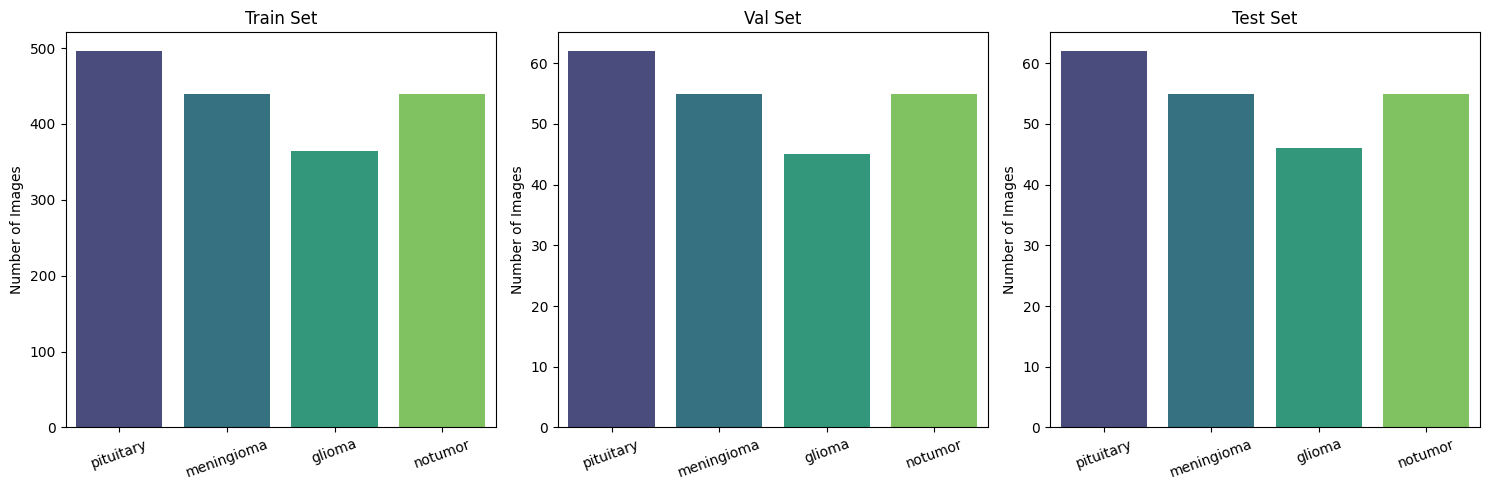

=== TRAIN SET ===
pituitary: 496 images
meningioma: 440 images
glioma: 364 images
notumor: 440 images

=== VAL SET ===
pituitary: 62 images
meningioma: 55 images
glioma: 45 images
notumor: 55 images

=== TEST SET ===
pituitary: 62 images
meningioma: 55 images
glioma: 46 images
notumor: 55 images



In [5]:
# Define dataset path
dataset_path = "/kaggle/working/Brain_Tumor_YOLO"
classes.append('notumor')

# Count images per one_class in each split
data_counts = {split: {one_class: 0 for one_class in classes} for split in splits}

for split in splits:
    image_folder = os.path.join(dataset_path, split, 'images')
    for img_file in os.listdir(image_folder):
        for one_class in classes:
            if one_class[:2] in img_file:  # Matching one_class prefix (e.g., "Tr-gl" for glioma)
                data_counts[split][one_class] += 1

# Plot the distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, split in enumerate(splits):
    sns.barplot(x=list(data_counts[split].keys()), y=list(data_counts[split].values()), ax=axes[i], palette="viridis")
    axes[i].set_title(f"{split.capitalize()} Set")
    axes[i].set_ylabel("Number of Images")
    axes[i].set_xticklabels(classes, rotation=20)

plt.tight_layout()
plt.show()

# Print the counts
for split in splits:
    print(f"=== {split.upper()} SET ===")
    for one_class, count in data_counts[split].items():
        print(f"{one_class}: {count} images")
    print()

In [6]:
def read_yolo_labels(label_path, img_width, img_height):
    """Reads YOLO label files and converts them to pixel coordinates."""
    boxes = []
    with open(label_path, "r") as file:
        for line in file.readlines():
            values = line.strip().split()
            class_id = int(values[0])
            x_center, y_center, width, height = map(float, values[1:])

            # Convert YOLO format (normalized) to pixel values
            x1 = int((x_center - width / 2) * img_width)
            y1 = int((y_center - height / 2) * img_height)
            x2 = int((x_center + width / 2) * img_width)
            y2 = int((y_center + height / 2) * img_height)

            boxes.append((class_id, x1, y1, x2, y2))
    return boxes

def visualize_annotations(one_class):
    """Visualizes bounding boxes for a specific class."""
    one_class_images = [img for img in os.listdir(image_folder) if one_class[:2] in img]  # Match prefix
    random.shuffle(one_class_images)
    one_class_images = one_class_images[:num_samples]

    fig, axes = plt.subplots(1, len(one_class_images), figsize=(15, 5))

    for i, img_file in enumerate(one_class_images):
        img_path = os.path.join(image_folder, img_file)
        label_path = os.path.join(label_folder, img_file.replace(".jpg", ".txt"))

        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_height, img_width, _ = image.shape

        # Draw bounding boxes
        if os.path.exists(label_path):
            boxes = read_yolo_labels(label_path, img_width, img_height)
            for class_id, x1, y1, x2, y2 in boxes:
                color = class_colors[class_id]  # Assign color based on class
                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                cv2.putText(image, classes[class_id], (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Show image
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"{one_class} Sample {i+1}")

    plt.show()

📌 Showing samples for: pituitary


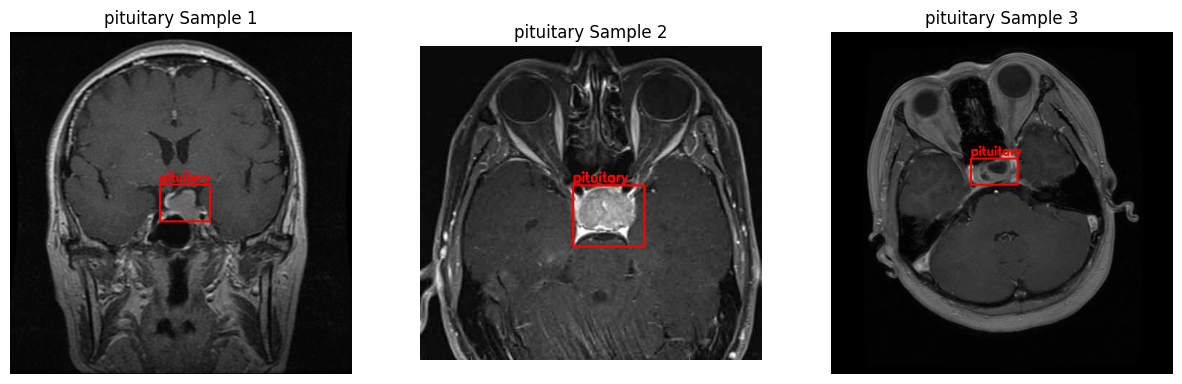

📌 Showing samples for: meningioma


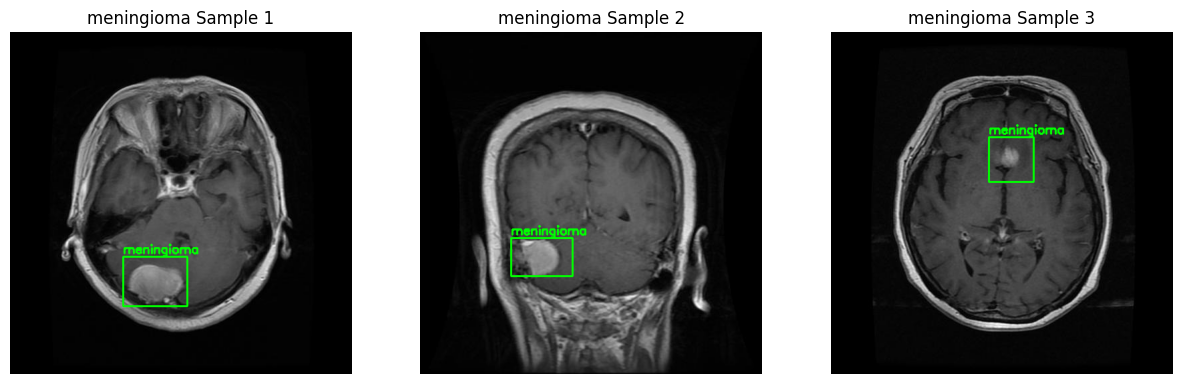

📌 Showing samples for: glioma


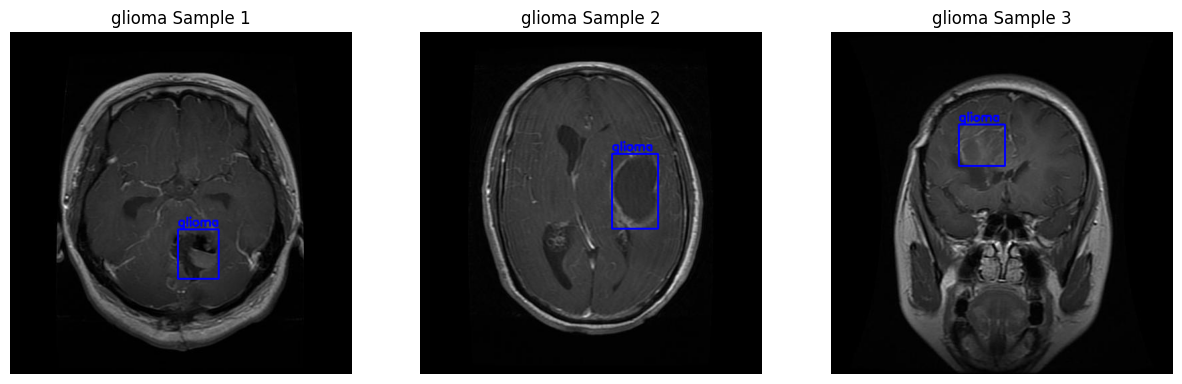

📌 Showing samples for: notumor


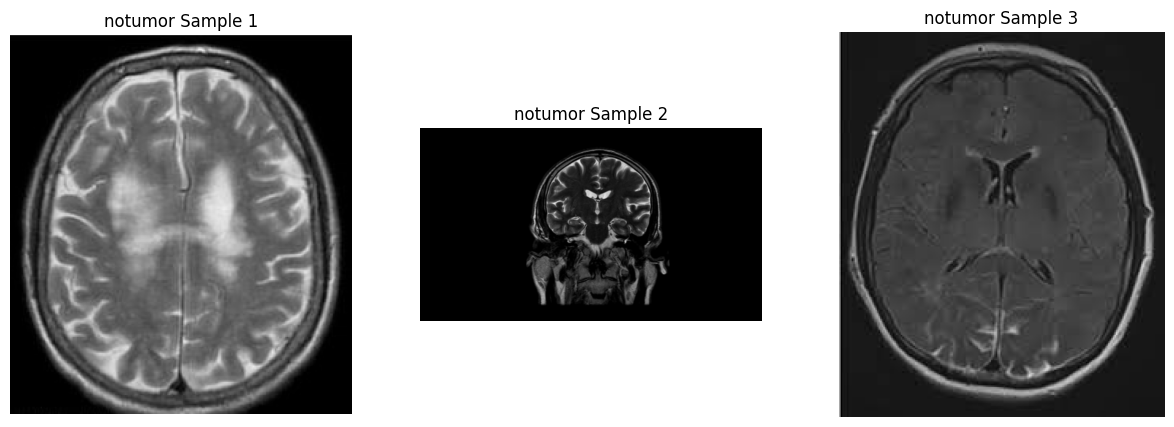

In [7]:
# Define dataset paths
split = "train"  # Change to 'val' or 'test' if needed
image_folder = os.path.join(dataset_path, split, "images")
label_folder = os.path.join(dataset_path, split, "labels")

# Class mappings
class_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # Unique color per class
num_samples = 3  # Number of samples to visualize per class

# Run visualization for each class
for class_name in classes:
    print(f"📌 Showing samples for: {class_name}")
    visualize_annotations(class_name)

In [8]:
!zip -r dataset.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/Brain_Tumor_YOLO/ (stored 0%)
  adding: kaggle/working/Brain_Tumor_YOLO/test/ (stored 0%)
  adding: kaggle/working/Brain_Tumor_YOLO/test/labels/ (stored 0%)
  adding: kaggle/working/Brain_Tumor_YOLO/test/labels/Tr-no_0181.txt (stored 0%)
  adding: kaggle/working/Brain_Tumor_YOLO/test/labels/Tr-gl_0491.txt (deflated 8%)
  adding: kaggle/working/Brain_Tumor_YOLO/test/labels/Tr-me_0514.txt (deflated 8%)
  adding: kaggle/working/Brain_Tumor_YOLO/test/labels/Tr-gl_0142.txt (deflated 8%)
  adding: kaggle/working/Brain_Tumor_YOLO/test/labels/Tr-no_0417.txt (stored 0%)
  adding: kaggle/working/Brain_Tumor_YOLO/test/labels/Tr-me_0253.txt (deflated 8%)
  adding: kaggle/working/Brain_Tumor_YOLO/test/labels/Tr-no_0151.txt (stored 0%)
  adding: kaggle/working/Brain_Tumor_YOLO/test/labels/Tr-pi_0510.txt (deflated 11%)
  adding: kaggle/working/Brain_Tumor_YOLO/test/labels/Tr-gl_0423

In [9]:
from IPython.display import FileLink
FileLink(r'dataset.zip')

/kaggle/working/dataset.zip